# TS8 - Filtrado No Lineal

## Introducción

Para mitigar el efecto de la interferencia arraigada al movimiento de la lìnea de base del ECG. Se estudiaran técnicas no lineales de estimación/substracción de la señal de movimiento base b(n).
Dada s la señal de ECG registrada con interferencias y \hat{x} la señal filtrada, una estimaciòn del ECG sin interferencias. 

$ \hat{x} = s - \hat{b}t $
A continuación, se detallarán los métodos para obtener la estimación de b(n).

## Metodología

### Método 1

El primer método de estimación es un **filtro de mediana**, que estima b como:

$
\hat{b} = \mathrm{med}_{600} \left( \mathrm{med}_{200}(s) \right)
$

siendo 
$\mathrm{med}_t(s)$ el operador de mediana de $t$ milisegundos que se aplica sobre la señal $s$, es decir: 

$ \hat{b} = \mathrm{med}(m[n], m[n-1], \ldots, m[n - 600 \cdot f_s]) $

donde:

$ m[n] = \mathrm{med}(s[n], s[n-1], \ldots, s[n - 200 \cdot f_s]) $
Es decir que este método consiste en tomar una ventana deslizante de tamaño impar, ordenar los valores y reemplazar el valor central por la mediana, esto resulta en el descarte de valores atípicos y logra preservar la forma general sin permitir que el ruido distorsione. 


### Método 2

En segundo lugar, se utiliza la técnica de **interpolación por medio de splines cúbicos**. 
Este método consiste en estimar el nivel isoeléctrico, es decir el momento donde la actividad eléctrica es aproximadamente nula a partir de deteciones provistas en ecg.mat (qrs_detections). Esto se realiza sobre el intervalo entre la onda P y Q, pues es el momento màs adecuado para estimar las características de la interferencia que originan el movimiento b(n). Este moemnto se asocia al intervalo en donde el impulso cardíaco es demorado al atravesar el nódulo aurículo-ventricular.

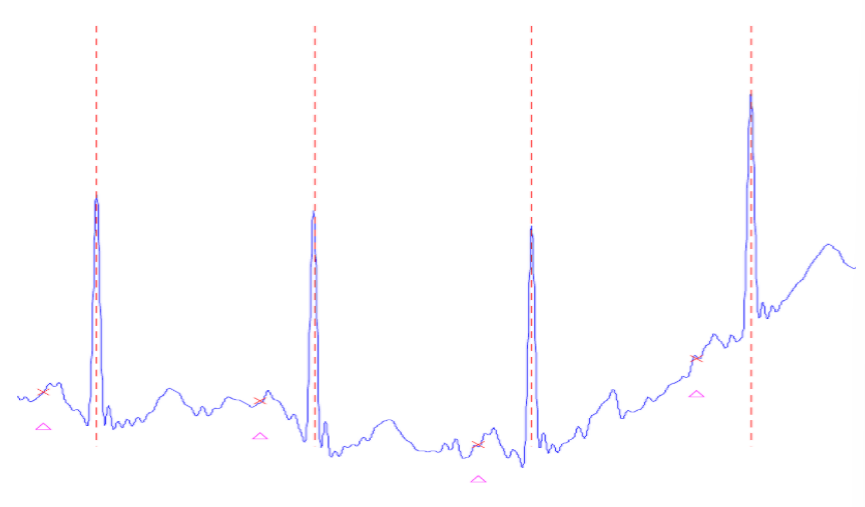

Para la localización del segmento PQ puede valerse de la localización de cada latido (líneas rojas verticales ($n_i$)) y a partir de la misma, anticipar un tiempo adecuado ($n_0$) de manera tal de **no incluir la onda P ni Q**.  
Esto resultará en un conjunto de valores

$
\mathcal{S} = \{ (m_i,\, s(m_i)) \mid i = 1, 2, \ldots, Q \} $

donde 

$m_i = n_i - n_0$ y $Q$ es la cantidad de latidos en el registro (1903).

Cabe destacar que la señal de línea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que este método requiere remuestrear dicha señal empleando la función de interpolación de spline:

$ \hat{b}(n) = \mathrm{spline}_3(\mathcal{S}, n) \mid n = 1, 2, \ldots, N $

donde la función $\mathrm{spline}_3$  realiza la interpolación para las N muestras de la señal s.

### Método 3

El tercer y último método consiste en un **filtro adaptado** para diseñar un detector de látidos. Este filtro busca detectar una forma conocida dentro de una señal ruidosa, como lo es la del ECG. A partir de la plantilla típica del complejo QRS, se puede obtener su correlación con la señal original para detectar los momentos en los cuales aparece esta forma de onda. Se espera que la salida del filtro tenga picos para los instantes en los cuales la señal se parece al patrón de comparación. Esto permite detectar los latidos.
Este método es ventajoso debido a su robustez frente a ruido y su alta sensibilidad a la forma QRS. Sin embargo, puede fallar si los latidos presentan una gran variación entre sí (debido a un ritmo cardíaco irregular o ruido). A su vez, puede llagr a detectar falsos latidos si no se utiloza un patrón representativo.

## Implementación

### Método 1. Filtro de MEDIANA



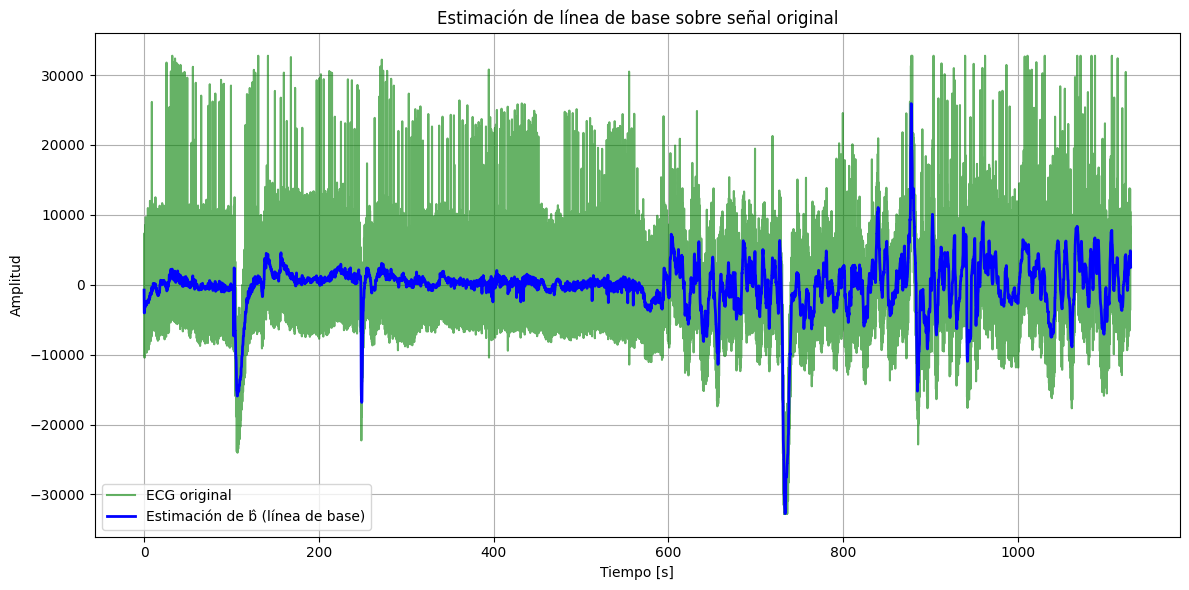

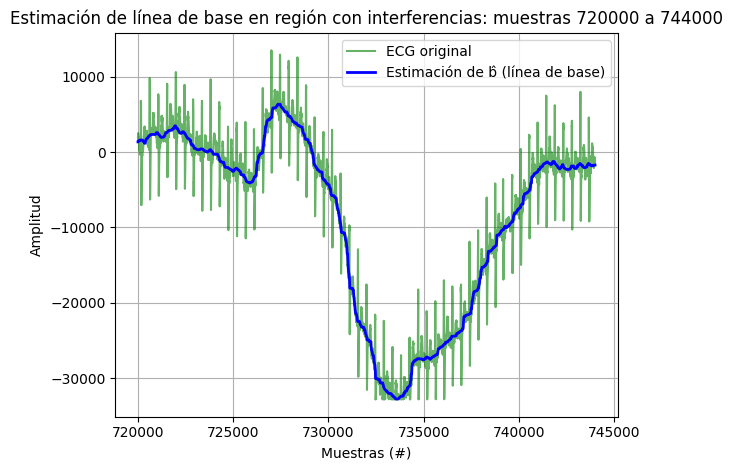

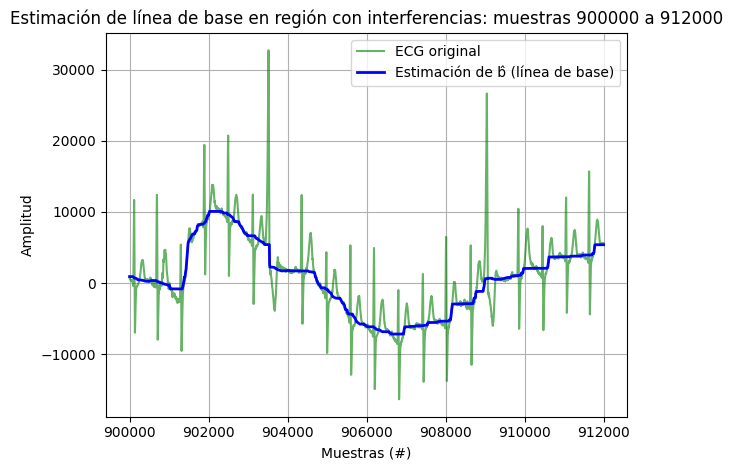

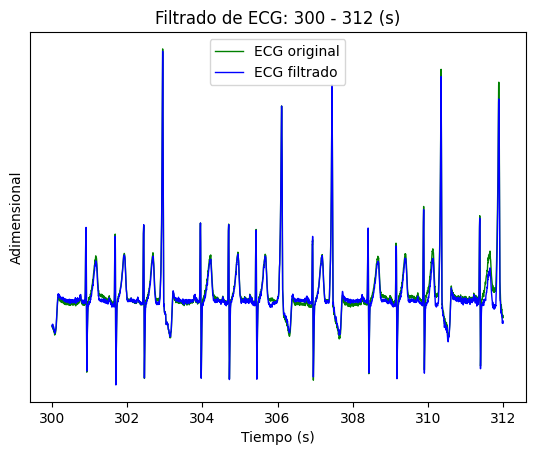

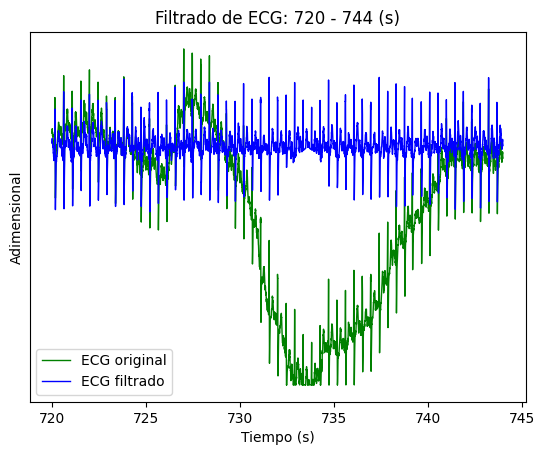

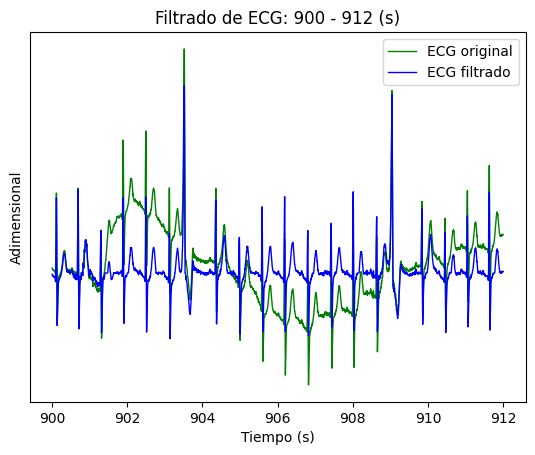

STD ECG original: 4914.70
STD ECG limpio:   2992.57
Varianza línea base estimada: 14636150.12
SNR estimado (limpio vs baseline): 7.19 dB


In [21]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 12 15:04:13 2025

@author: iremo
"""
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write
from pytc2.sistemas_lineales import plot_plantilla
from scipy.signal import sosfiltfilt, filtfilt, medfilt
def vertical_flaten(a):

    return a.reshape(a.shape[0],1)


fs_ecg = 1000 # Hz
sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead']).flatten()
N = len(ecg_one_lead)

nyq_frec = fs_ecg/2

w200 = int(0.2 * fs_ecg)
w600 = int(0.6 * fs_ecg)

if w200 % 2 == 0:
    w200 += 1
if w600 % 2 == 0:
    w600 += 1

filtroM = medfilt(ecg_one_lead, kernel_size=w200)
b = medfilt(filtroM, kernel_size=w600)

ecgFiltrada = ecg_one_lead - b

t = np.arange(N) / fs_ecg

plt.figure(figsize=(12, 6))
plt.plot(t, ecg_one_lead, label='ECG original', color='green', alpha=0.6)
plt.plot(t, b, label='Estimación de b̂ (línea de base)', color='blue', linewidth=2)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Estimación de línea de base sobre señal original")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

regs_interes = (
        np.array([12, 12.4]) *60*fs_ecg, # minutos a muestras
        np.array([15, 15.2]) *60*fs_ecg, # minutos a muestras
        )
for ii in regs_interes:
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([N, ii[1]]), dtype='uint')
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region],label='ECG original', color='green', alpha=0.6)
    plt.plot(zoom_region, b[zoom_region],  label='Estimación de b̂ (línea de base)', color='blue', linewidth=2)
    plt.title(f'Estimación de línea de base en región con interferencias: muestras {int(ii[0])} a {int(ii[1])}')
    plt.ylabel('Amplitud')
    plt.xlabel('Muestras (#)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


regs_interes = ( 
        np.array([5, 5.2]) *60*fs_ecg, # minutos a muestras
        np.array([12, 12.4]) *60*fs_ecg, # minutos a muestras
        np.array([15, 15.2]) *60*fs_ecg, # minutos a muestras
        )

fig_sz_x = 25
fig_sz_y = 10

for ii in regs_interes:

    zoom_region = np.arange(np.max([0, ii[0]]), np.min([N, ii[1]]), dtype='uint')
    plt.plot(zoom_region/fs_ecg, ecg_one_lead[zoom_region], label='ECG original', color='green', linewidth=1)
    plt.plot(zoom_region/fs_ecg, ecgFiltrada[zoom_region], label='ECG filtrado', color='blue', linewidth=1)
    plt.title('Filtrado de ECG: {:3.0f} - {:3.0f} (s)'.format(ii[0]/fs_ecg, ii[1]/fs_ecg) )
    plt.ylabel('Adimensional')
    plt.xlabel('Tiempo (s)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

std_original = np.std(ecg_one_lead)
std_limpio = np.std(ecgFiltrada)
var_b = np.var(b)
snr = 10 * np.log10(np.sum(ecgFiltrada**2) / np.sum(b**2))


print(f"STD ECG original: {std_original:.2f}")
print(f"STD ECG limpio:   {std_limpio:.2f}")
print(f"Varianza línea base estimada: {var_b:.2f}")
print(f"SNR estimado (limpio vs baseline): {snr:.2f} dB")




**Funcionamiento:** 

Para implementar esta técnica de filtrado, en primer lugar se definieron dos ventanas de tamaño 200 ms y 600 ms para aplicar dos filtros de mediana en cascada, uno corto seguido de uno largo. Luego, mediante la función medfilt, se aplica el filtro. Esta función reemplaza cada muestra de la señal por la mediana de las muestras dentro de una ventada centrada que se va desplazando por todas las posiciones . 
El uso de una ventana corta asegura capturar fluctuaciones rápidas, preserva picos y transiciones abruptas, sin embargo, no elimina desplazamientos lentos. Una ventana más larga elimina variaciones lentas y suaviza oscilaciones grandes, no obstante, puede aplanar o deformar los picos si se lo implementa directamente sobre la señal. Aplicar el filtro dos veces es una estrategia para separar escalas, en primer lugar, se eliminan detalles rápidos como los complejos QRS. En la pasada con la ventana más grande se captura la línea de base.


**Resultados:**

Las figuras obtenidas sugieren que el filtro de mediana es una gran opción para filtrar una señal de ECG. Su carácter no lineal evita suavizar bordes o picos como lo haría un filtro promediador, (vemos en las figuras que se preserva la forma de onda original perfectamente). Además, su implementación es muy sencilla y evita la necesidad de diseñar un filtro, asimismo, es muy rápido a nivel computacional incluso utilizando ventanas grandes.
Sin embargo, este método presenta varias desventajas, en primer lugar, dado que no promedia, se observan transiciones abruptas. Esto resulta en una estimación de la línea de base que no parece ser suave, lo que puede ser arrastrado a la señal filtrada. 
Por las razones discutidas, se concluye que esta herramienta es de gran utilidad para visualizar la señal y detectar eventos abruptos, siempre y cuando el procesamiento posterior no involucre derivar o hacer análisis espectral (los saltos bruscos podrían introducir energía en alta frecuencia).

### Método 2: Estimación por interpolación cúbica spline

Para estimar la línea de base se usó la información de los latidos detectados y el segmento PQ, luego se construtó una estimación de b por medio de interpolación cúbica spline. 
El método a seguir fue:
1. A partir de cada latido detectado, definir un punto anterior dentro del segmento PQ: Es decir para un latido $n_i$, elegir  $ m_i = n_i - n_0$.
2. Obtener el valor de la señal en el instante anterior $s(m_i)$.
3. Construir $S = {m_i,s(m_i)}$
4. Interpolar los valores usando splines cúbicos para reconstruir una señal de línea de base que tenga la misma longitud que la del ecg original.


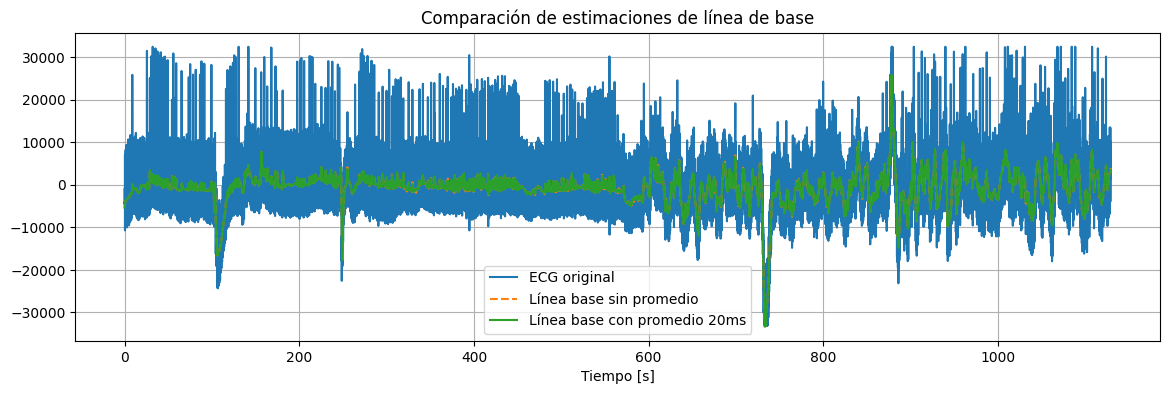

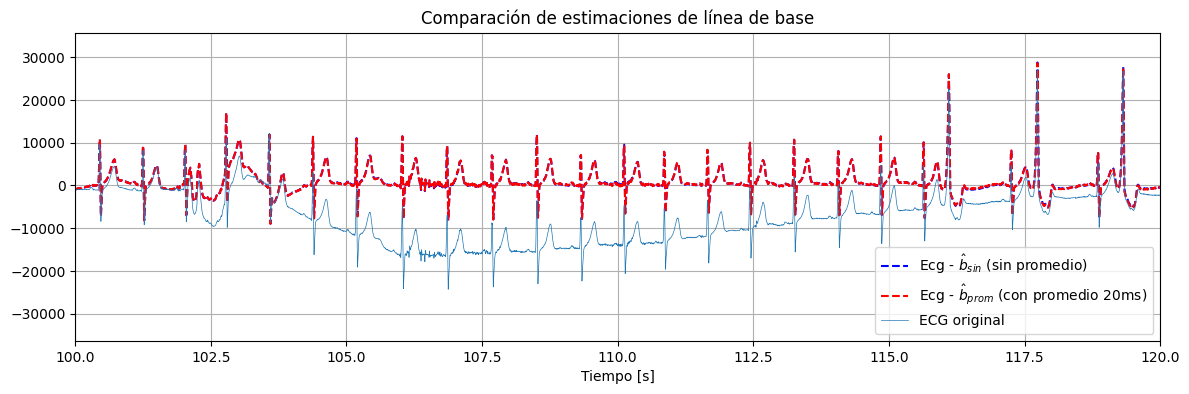

In [22]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import scipy.io as sio


fs_ecg = 1000
nyq_frec = fs_ecg / 2


mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg = mat_struct['ecg_lead'].flatten()
qrs = mat_struct['qrs_detections'].flatten()

ecg = ecg - np.mean(ecg)
t_ecg = np.arange(len(ecg)) / fs_ecg

n0 = int(0.07 * fs_ecg)  # 70 ms antes del QRS, dentro del segmento PQ
mi = qrs - n0  # Instantes donde se estima el valor de línea base

si_sin_prom = ecg[mi]
spline_sin = interpolate.interp1d(mi, si_sin_prom, kind='cubic', fill_value="extrapolate")
b_hat_sin_prom = spline_sin(np.arange(len(ecg)))

ventana_prom = int(0.010 * fs_ecg)  # +-10 muestras = 20 ms total

si_con_prom = []
for m in mi:
    inicio = max(0, m - ventana_prom)
    fin = min(len(ecg), m + ventana_prom + 1)
    si_con_prom.append(np.mean(ecg[inicio:fin]))
si_con_prom = np.array(si_con_prom)

spline_con = interpolate.interp1d(mi, si_con_prom, kind='cubic', fill_value="extrapolate")
b_hat_con_prom = spline_con(np.arange(len(ecg)))

ecg_filtrado_con = ecg - b_hat_con_prom
ecg_filtrado_sin = ecg - b_hat_sin_prom


plt.figure(figsize=(14, 4))
plt.plot(t_ecg, ecg, label='ECG original')
plt.plot(t_ecg, b_hat_sin_prom, '--', label='Línea base sin promedio')
plt.plot(t_ecg, b_hat_con_prom, '-', label='Línea base con promedio 20ms')
plt.title('Comparación de estimaciones de línea de base')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(t_ecg, ecg_filtrado_sin, '--', color = 'blue',label='Ecg - $\hat{b}_{sin}$ (sin promedio)')
plt.plot(t_ecg, ecg_filtrado_con, '--', color = 'red', label='Ecg - $\hat{b}_{prom}$ (con promedio 20ms)')
plt.plot(t_ecg, ecg, linewidth = '0.5', label='ECG original')
plt.title('Comparación de estimaciones de línea de base')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.xlim(100,120)
plt.grid(True)
plt.show()


En este método, se considera que la señal de ECG puede representarse como la suma de una señal limpia y una función $\hat{b}$, que modela la línea de base sobre la cual se encuentra montada. El objetivo es estimar esta componente lenta $\hat{b}$ y sustraerla de la señal original para obtener una señal corregida.
Para estimar $\hat{b}$ , se aprovechan instantes específicos donde idealmente no debería haber actividad eléctrica significativa en el ECG, como ocurre aproximadamente 70 ms antes del complejo QRS, dentro del segmento PR. En estos puntos, se estima el valor de la línea de base y luego se interpola sobre toda la señal mediante splines cúbicos.
Se evaluaron dos variantes:  $\hat{b_{sin}}$ (utilizando directamente el valor de la señal en el instante seleccionado), y $\hat{b_{con}}$ (calculando el promedio de 20 muestras centradas en ese instante). La segunda opción es ventajosa pues utiliza un valor promediado, además, promediar sobre una ventana de 20 ms (equivalente a un período de 50 Hz), atenúa la interferencia de red eléctrica y sus armónicos, gracias a que dicha ventana introduce ceros de transmisión exactamente en esas frecuencias.
Gracias a la tercer figura, podemos observar que la señal corregida conversa la morfologóa original del ECG y está centrada por lo que la línea de base fue removida correctamente. Dado que el ecg corregido restando el estimador con o sin promedio son coincidentes, podemos decir que promediar no trajó muchas ventajas.

### Método 3: Filtrado de señal ECG y detección de latidos por correlación

Detalle de método: 

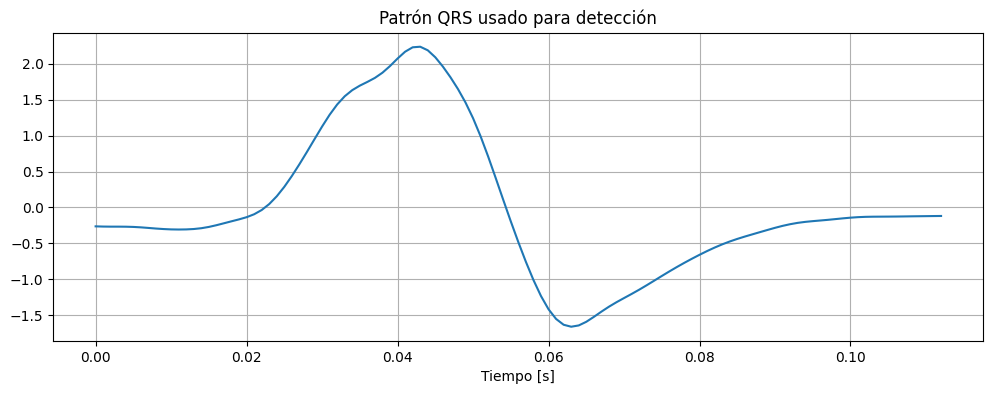

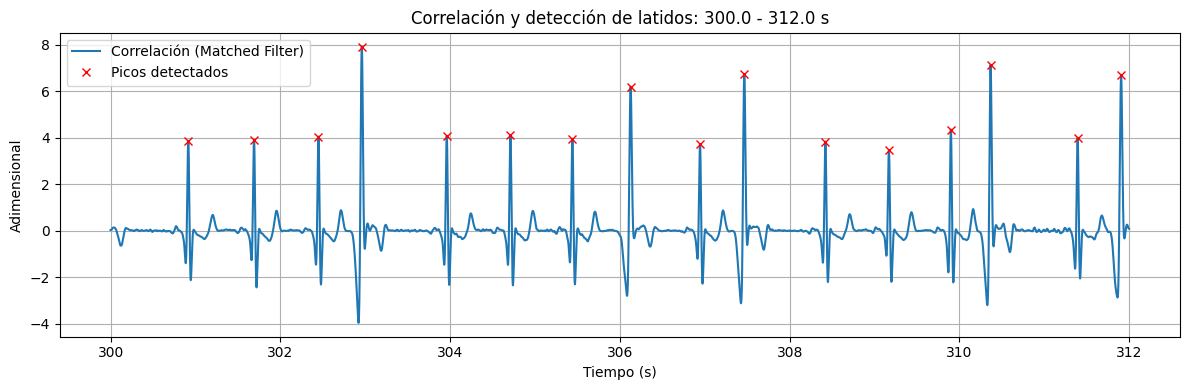

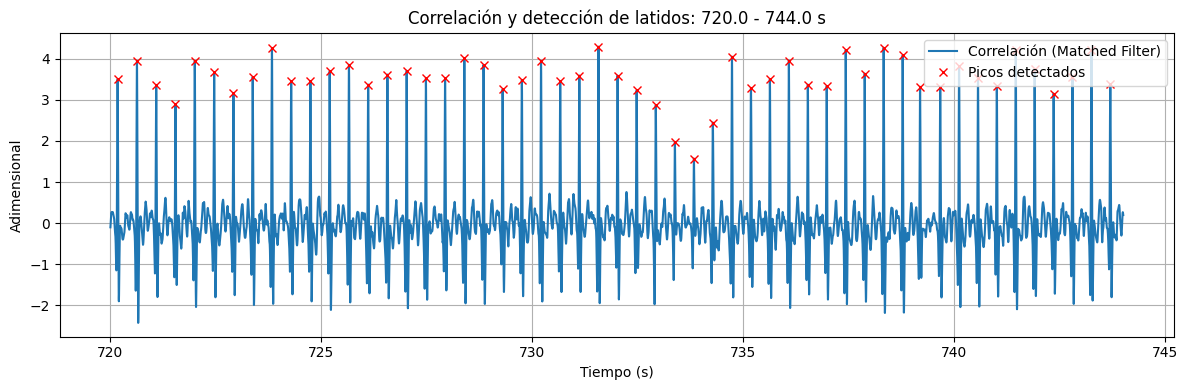

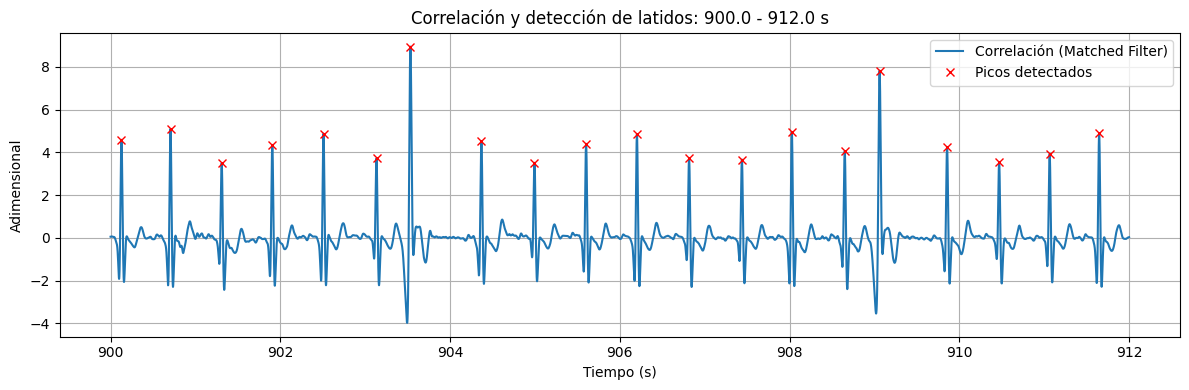

Latidos detectados correctamente: 1902
Latidos detectados que no lo eran): 2
Latidos verdaderos no detectados: 1
Fracción de latidos detectados (sensibilidad): 1.00
Fraccion de latidos detectados que eran verdaderos latidos (Valor Predictivo Positivo (PPV)): 1.00


In [23]:
"""
@author: iremo
"""

import numpy as np
from scipy import signal as sig
from scipy.signal import correlate, find_peaks
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import sosfiltfilt, filtfilt

#%% Diseño del filtro

fs_ecg = 1000
nyq_frec = fs_ecg / 2


mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg = mat_struct['ecg_lead'].flatten()
qrs = mat_struct['qrs_pattern1'].flatten()

ecg = (ecg - np.mean(ecg)) / np.std(ecg)
qrs =( qrs - np.mean(qrs)) / np.std(qrs)


t_qrs = np.arange(len(qrs)) / fs_ecg

t_ecg = np.arange(len(ecg)) / fs_ecg


plt.figure(figsize=(12, 4))
plt.plot(t_qrs, qrs)
plt.title('Patrón QRS usado para detección')
plt.xlabel('Tiempo [s]')
plt.grid(True)
plt.show()


qrs_matched = qrs[::-1]
corr = np.convolve(ecg, qrs_matched, mode='same')
corr = (corr - np.mean(corr)) / np.std(corr)

peaks, _ = find_peaks(corr, height = 1.0, distance=fs_ecg*0.3)


regs_interes = ( 
        np.array([5, 5.2]) *60*fs_ecg,
        np.array([12, 12.4]) *60*fs_ecg, 
        np.array([15, 15.2]) *60*fs_ecg, 
        )

fig_sz_x = 25
fig_sz_y = 10

for ii in regs_interes:
    

    zoom_region = np.arange(np.max([0, int(ii[0])]), np.min([N, int(ii[1])]), dtype='uint')
    

    mask_peaks = (t_ecg[peaks] >= zoom_region[0]/fs_ecg) & (t_ecg[peaks] <= zoom_region[-1]/fs_ecg)
    peaks_in_region = peaks[mask_peaks]

    plt.figure(figsize=(12, 4))
    plt.plot(t_ecg[zoom_region], corr[zoom_region], label='Correlación (Matched Filter)')
    plt.plot(t_ecg[peaks_in_region], corr[peaks_in_region], 'rx', label='Picos detectados')

    plt.title('Correlación y detección de latidos: {:.1f} - {:.1f} s'.format(ii[0]/fs_ecg, ii[1]/fs_ecg))
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Adimensional')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


VP = 0 #Verdaderos positivos (latidos reales detectados)
FP = 0 # deteccion sin latido
FN = 0 # falsos negativos (latidos reales que no fueron detectados)

qrsVerdaderos = mat_struct['qrs_detections'].flatten()
tolerancia = 0.05  # segundos
ventana = int(tolerancia * fs_ecg)


latidos_usados = np.zeros(len(qrsVerdaderos), dtype=bool)

for pico in peaks:
    acierto = False
    for i, real in enumerate(qrsVerdaderos):
        if not latidos_usados[i] and abs(pico - real) <= ventana:
            VP = VP + 1
            latidos_usados[i] = True  
            acierto = True
            break  
    if not acierto:
        FP = FP + 1
        
FN = np.sum(latidos_usados == False)


fracTotal = VP / (VP + FN)
fracDetectados = VP / (VP + FP)

print(f"Latidos detectados correctamente: {VP}")
print(f"Latidos detectados que no lo eran): {FP}")
print(f"Latidos verdaderos no detectados: {FN}")
print(f"Fracción de latidos detectados (sensibilidad): {fracTotal:.2f}")
print(f"Fraccion de latidos detectados que eran verdaderos latidos (Valor Predictivo Positivo (PPV)): {fracDetectados:.2f}")

Los resultados obtenidos muestran que el sistema de detección basado en un filtro adaptado por correlación, (con un preprocesamiento previo de línea de base), alcanza niveles clínicamente muy aceptables de desempeño. La baja tasa de falsos positivos y negativos es evidencia de una implementación sólida y confiable. No obstante, el detector de latidos basado en filtro adaptado no es tan general como los dos métodos previos. Esto se atribuye a que solo tendrá un buen funcionamiento en tanto y en cuanto los pacientes tengan un complejo QRS similar al patrón usado. Si se usa un latido de otro paciente, la técnica podría perder eficacia por diferencias en la forma del QRS. Una mejora sería usar un promedio de varios latidos reales del mismo paciente como patrón de referencia, de este modo, el filtro sería más generalizado y podría implementarse en otros pacientes.

## Bonus

Para mejorar los métodos implementados, una posibilidad es utilizar técnicas multirate. Para este caso, se podría diezmar el ECG ya que esto reduce el costo computaional.
Para ello, se implementó la técnica de diezmado con M = 2 y M = 4. Esto produce una tasa de muestro reducida por un factor de 2 y 4. Luego se realiza una interpolación para vovler al eje temporal original y realizar la substracción del estimador de línea de base a la señal original.
También se probó la técnica de interpolación para mejorar la resolución temporal y ver los resultados en el estimador b.

#### Mejoras en el método 1: Filtro de doble mediana.

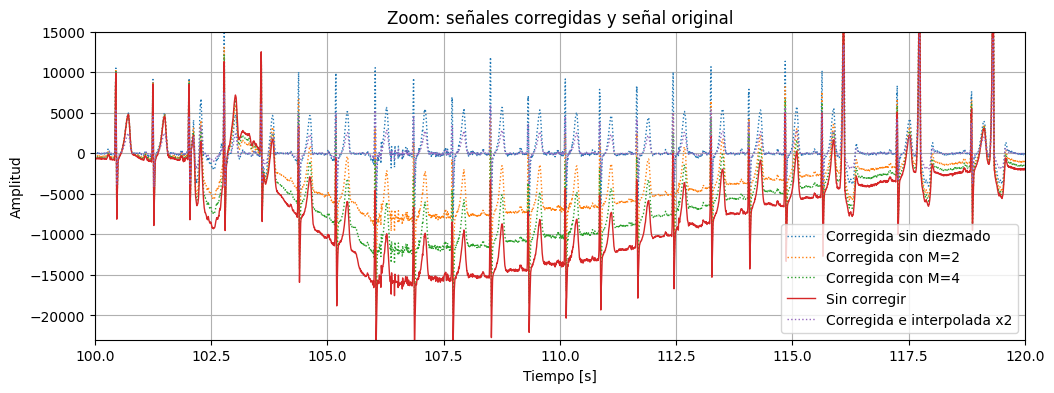

In [24]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import median_filter

def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('ecg.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead']).flatten()
N = len(ecg_one_lead)
t = np.arange(N) / fs_ecg

def filtro_antialias(fs_original, fs_diezmado, orden=4):
    nyq = fs_original / 2
    fc = 0.8 * (fs_diezmado / 2)
    wnorm = fc / nyq
    sos = sig.butter(orden, wnorm, btype='lowpass', output='sos')
    return sos

def interpolar_zeros(signal_diezmada, M):
    upsampled = np.zeros(len(signal_diezmada) * M)
    upsampled[::M] = signal_diezmada
    sos = sig.butter(4, 1/M, btype='lowpass', output='sos')
    return sig.sosfiltfilt(sos, upsampled)

w200 = int(0.2 * fs_ecg)
w600 = int(0.6 * fs_ecg)
b_sin = median_filter(ecg_one_lead, size=w200, mode='reflect')
b_sin = median_filter(b_sin, size=w600, mode='reflect')
ecg_corr_sin = ecg_one_lead - b_sin

M2 = 2
fs2 = fs_ecg // M2
sos2 = filtro_antialias(fs_ecg, fs2)
ecg_m2 = sig.sosfiltfilt(sos2, ecg_one_lead)[::M2]
w200_2 = int(0.2 * fs2)
w600_2 = int(0.6 * fs2)
b_m2 = median_filter(ecg_m2, size=w200_2, mode='reflect')
b_m2 = median_filter(b_m2, size=w600_2, mode='reflect')
b_interp2 = interpolar_zeros(b_m2, M2)[:N]
ecg_corr_m2 = ecg_one_lead - b_interp2

M4 = 4
fs4 = fs_ecg // M4
sos4 = filtro_antialias(fs_ecg, fs4)
ecg_m4 = sig.sosfiltfilt(sos4, ecg_one_lead)[::M4]

w200_4 = int(0.2 * fs4)
w600_4 = int(0.6 * fs4)
b_m4 = median_filter(ecg_m4, size=w200_4, mode='reflect')
b_m4 = median_filter(b_m4, size=w600_4, mode='reflect')

b_interp4 = interpolar_zeros(b_m4, M4)[:N]
ecg_corr_m4 = ecg_one_lead - b_interp4

def aumentar_resolucion(signal_original, L):
    upsampled = np.zeros(len(signal_original) * L)
    upsampled[::L] = signal_original
    sos = sig.butter(4, 1 / L, btype='lowpass', output='sos')
    return sig.sosfiltfilt(sos, upsampled)

L = 2
ecg_corr_inter2L = aumentar_resolucion(ecg_corr_sin, L)
t_inter2L = np.arange(len(ecg_corr_inter2L)) / (fs_ecg * L)


plt.figure(figsize=(12, 4))
plt.plot(t, ecg_corr_sin, label='Corregida sin diezmado', linestyle=':', linewidth=1)
plt.plot(t, ecg_corr_m2, label='Corregida con M=2', linestyle=':', linewidth=1)
plt.plot(t, ecg_corr_m4, label='Corregida con M=4', linestyle=':', linewidth=1)
plt.plot(t, ecg_one_lead, label='Sin corregir', linewidth=1)
plt.plot(t_inter2L, ecg_corr_inter2L, label='Corregida e interpolada x2', linewidth=1,linestyle=':')
plt.xlim(100, 120)
plt.ylim(-23000, 15000)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Zoom: señales corregidas y señal original')
plt.grid(True)
plt.legend()
plt.show()


Los resultados obtenidos muestran que el diezmado, combinado con un filtrado antialias adecuado, permite reducir la tasa de muestreo sin pérdida significativa de fidelidad en la señal. Esta estrategia resulta útil para disminuir la cantidad de datos a procesar y, en consecuencia, el costo computacional, manteniendo la información esencial del ECG para el análisis realizado. Cabe destacar que realizar un filtrado previo es imprescindible, ya que permite eliminar las componentes de alta frecuencia que superarían el nuevo límite de Nyquist. De este modo, se evita el aliasing.

El gráfico con zoom entre 110 y 120 segundos permite observar que, a medida que aumenta el factor de diezmado, la estimación de la línea de base se vuelve menos precisa. Este comportamiento es esperable, ya que existe un compromiso inherente entre la reducción del costo computacional y la resolución temporal de la estimación: al tener menos muestras, la línea de base pierde detalle temporal.

Por otro lado, los resultados de la segunda figura evidencian que la interpolación 2× aplicada a la señal corregida sin diezmado no aporta mejoras adicionales. Esto se debe a que la señal original, procesada sin reducción de muestras, ya permite una estimación efectiva de la línea de base. Como resultado, la señal corregida permanece centrada alrededor de cero, sin requerir mayor resolución temporal.


#### Mejoras en el MÉTODO 3: (Matched filter)

En el contexto del filtro adaptado, el requerimiento de resolución temporal no es elevado ya que los latidos tienen una duración de aproximadamente 100 a 150 ms. (Con una fs de 1000 Hz tendríamos 1 ms por muestra). Dado que el objetivo no es reconstruir la señal, sino solamente detectar los picos en forma clara, el diezmado promete ser una buena opción para reducir el ruido, y lograr una correlación más rápida y robusta. A su vez, otra posible opción es aplicar un filtro sobre la señal de ecg antes de correlarla.

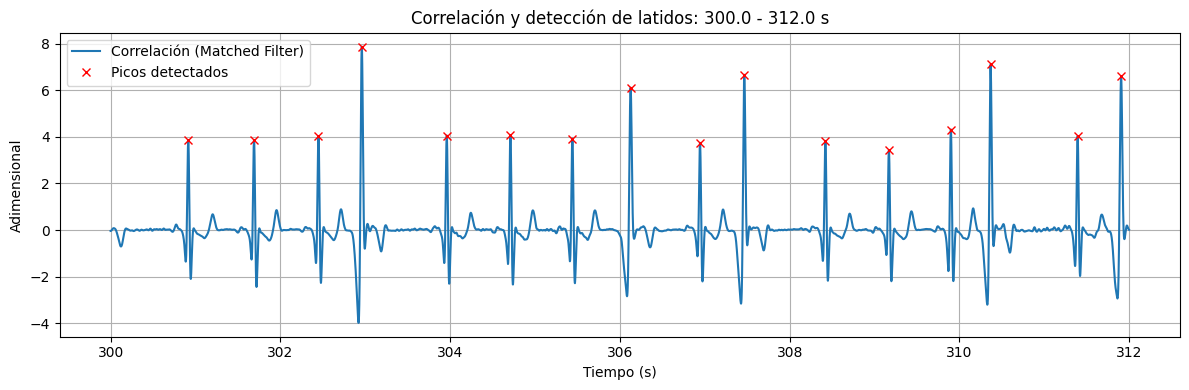

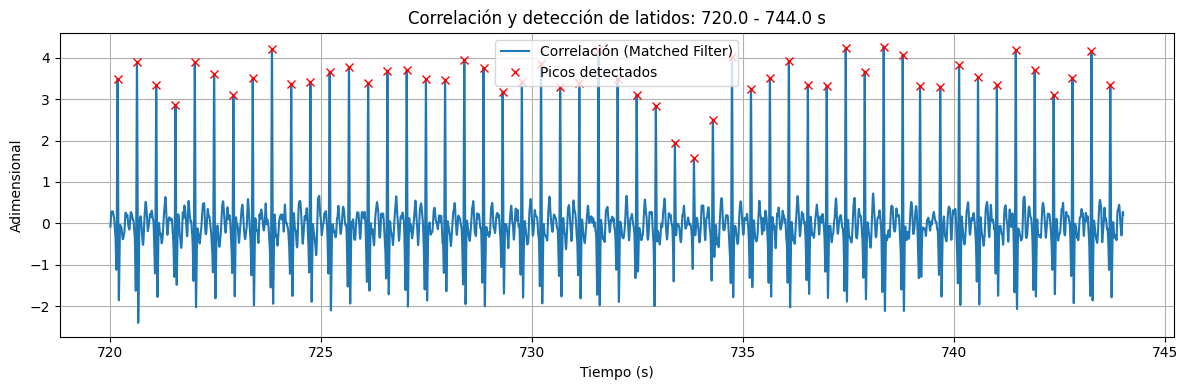

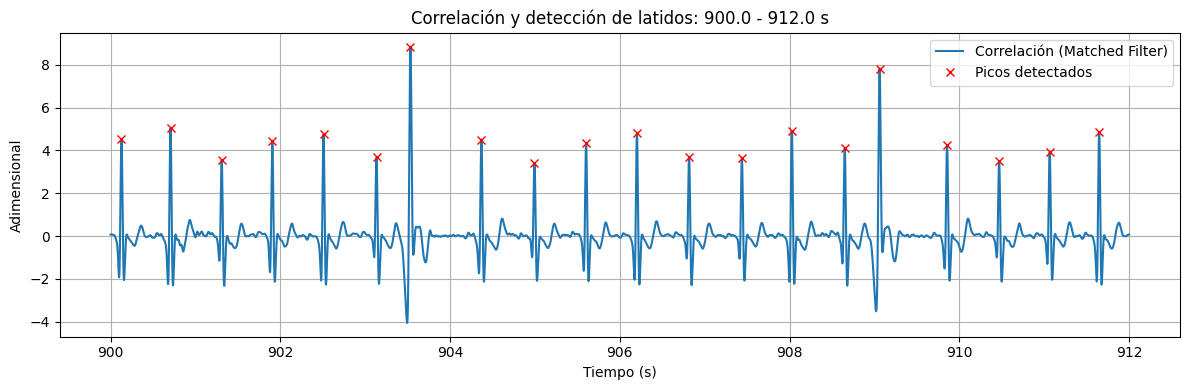

Latidos detectados correctamente: 1902
Latidos detectados que no lo eran): 2
Latidos verdaderos no detectados: 1
Fracción de latidos detectados (sensibilidad): 1.00
Fraccion de latidos detectados que eran verdaderos latidos (Valor Predictivo Positivo (PPV)): 1.00


In [25]:
"""
@author: iremo
"""

import numpy as np
from scipy import signal as sig
from scipy.signal import correlate, find_peaks
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import sosfiltfilt, filtfilt

#%% Diseño del filtro

fs_ecg = 1000
nyq_frec = fs_ecg / 2


mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs = mat_struct['qrs_pattern1'].flatten()

ecg = (ecg - np.mean(ecg)) / np.std(ecg)

ws1 = 0.1 # Hz
wp1 = 1.0 # Hz
wp2 = 35 # Hz
ws2 = 50 # Hz
bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')
ECG_f_butt  = sosfiltfilt(bp_sos_butter, ecg.flatten())


hb1 =( hb1 - np.mean(hb1)) / np.std(hb1)
hb2 =( hb2 - np.mean(hb2)) / np.std(hb2)
qrs =( qrs - np.mean(qrs)) / np.std(qrs)

#un vector de tiempo para cada patron
t_hb1 = np.arange(len(hb1)) / fs_ecg
t_hb2 = np.arange(len(hb2)) / fs_ecg
t_qrs = np.arange(len(qrs)) / fs_ecg

t_ecg = np.arange(len(ecg)) / fs_ecg

#%% Detección por correlación

qrs_matched = qrs[::-1]
corr = np.convolve(ECG_f_butt, qrs_matched, mode='same')
corr = (corr - np.mean(corr)) / np.std(corr)

peaks, _ = find_peaks(corr, height = 1.0, distance=fs_ecg*0.3)


regs_interes = (
    np.array([5, 5.2]) * 60 * fs_ecg,
    np.array([12, 12.4]) * 60 * fs_ecg,
    np.array([15, 15.2]) * 60 * fs_ecg,
)

for ii in regs_interes:

    zoom_region = np.arange(np.max([0, int(ii[0])]), np.min([len(corr), int(ii[1])]), dtype='uint')
    mask_peaks = (peaks >= zoom_region[0]) & (peaks <= zoom_region[-1])
    peaks_in_region = peaks[mask_peaks]
    plt.figure(figsize=(12, 4))
    plt.plot(t_ecg[zoom_region], corr[zoom_region], label='Correlación (Matched Filter)')
    plt.plot(t_ecg[peaks_in_region], corr[peaks_in_region], 'rx', label='Picos detectados')
    plt.title('Correlación y detección de latidos: {:.1f} - {:.1f} s'.format(ii[0]/fs_ecg, ii[1]/fs_ecg))
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Adimensional')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#fraccion de detecciones verdaderas
VP = 0 #Verdaderos positivos (latidos reales detectados)
FP = 0 # deteccion sin latido
FN = 0 # falsos negativos (latidos reales que no fueron detectados)

qrsVerdaderos = mat_struct['qrs_detections'].flatten()
tolerancia = 0.05  # segundos
ventana = int(tolerancia * fs_ecg)


latidos_usados = np.zeros(len(qrsVerdaderos), dtype=bool)

for pico in peaks:
    acierto = False
    for i, real in enumerate(qrsVerdaderos):
        if not latidos_usados[i] and abs(pico - real) <= ventana:
            VP = VP + 1
            latidos_usados[i] = True 
            acierto = True
            break
    if not acierto:
        FP = FP + 1
        
FN = np.sum(latidos_usados == False)


fracTotal = VP / (VP + FN)
fracDetectados = VP / (VP + FP)

print(f"Latidos detectados correctamente: {VP}")
print(f"Latidos detectados que no lo eran): {FP}")
print(f"Latidos verdaderos no detectados: {FN}")
print(f"Fracción de latidos detectados (sensibilidad): {fracTotal:.2f}")
print(f"Fraccion de latidos detectados que eran verdaderos latidos (Valor Predictivo Positivo (PPV)): {fracDetectados:.2f}")

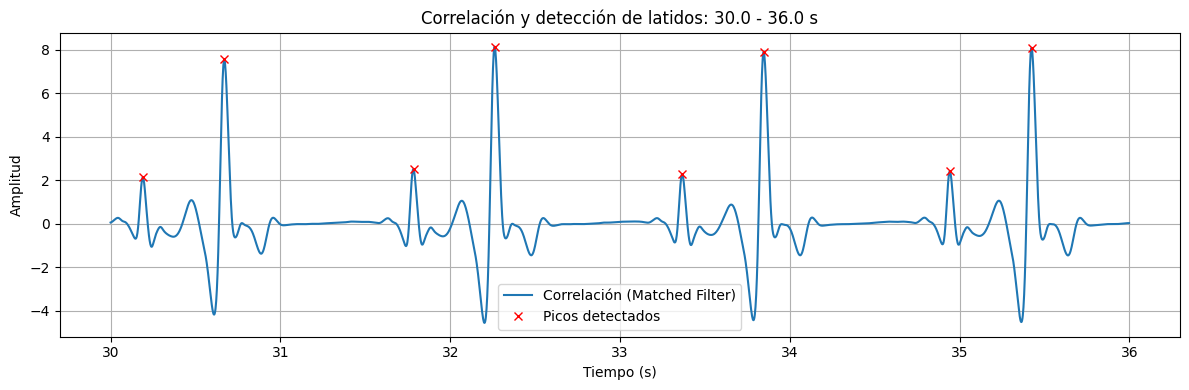

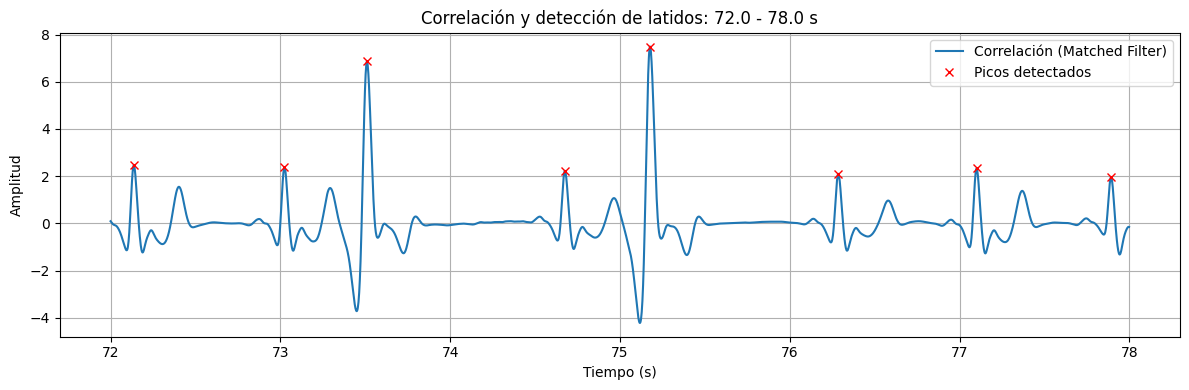

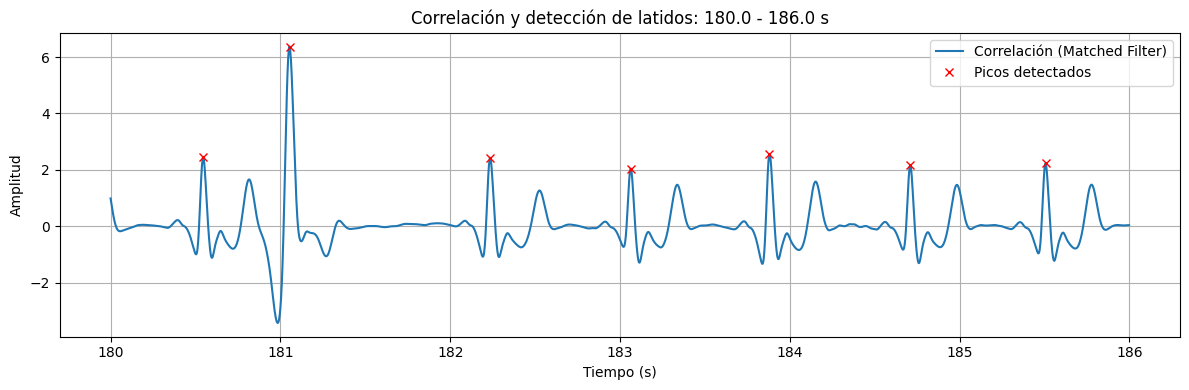

Latidos detectados correctamente (VP): 1899
Latidos detectados que no eran latidos reales (FP): 7
Latidos reales no detectados (FN): 4
Sensibilidad (fracción de latidos reales detectados): 1.00
Valor Predictivo Positivo (fracción de detecciones verdaderas): 1.00


In [26]:
"""
Filtrado de señal ECG y detección de latidos por correlación
@author: iremo
"""

import numpy as np
from scipy import signal as sig
from scipy.signal import correlate, find_peaks
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import sosfiltfilt, filtfilt

#%% Diseño del filtro

fs_ecg = 1000
nyq_frec = fs_ecg / 2


mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs = mat_struct['qrs_pattern1'].flatten()

ecg = (ecg - np.mean(ecg)) / np.std(ecg)

ws1 = 0.1  # Hz
wp1 = 1.0  # Hz
wp2 = 35   # Hz
ws2 = 50   # Hz
bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec,ws=np.array([ws1, ws2]) / nyq_frec,gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')

ECG_f_butt = sosfiltfilt(bp_sos_butter, ecg.flatten())


#DIEZMADO POR FACTOR DE 4
M = 2
fs_diezmado = fs_ecg / M #nueva frec de muestreo
#filtro antialiasing que filtre las frecuencias superiores al nuevo nyquist. 0,4 para no estar demasiado cerca del limite
fc = 0.4 * fs_diezmado 

b_aa, a_aa = sig.butter(5, fc / nyq_frec, btype='low')
ECG_filtrado_aa = filtfilt(b_aa, a_aa, ECG_f_butt)

ECG_diezmado = ECG_filtrado_aa[::M]
t_ecg_diezmado = np.arange(len(ECG_diezmado)) / fs_diezmado

qrs = (qrs - np.mean(qrs)) / np.std(qrs)
t_qrs = np.arange(len(qrs)) / fs_ecg 

qrs_matched = qrs[::-1]

corr = np.convolve(ECG_diezmado, qrs_matched, mode='same')
corr = (corr - np.mean(corr)) / np.std(corr)

peaks, _ = find_peaks(corr, height=1.0, distance=fs_diezmado * 0.3)

regs_interes = (
    np.array([0.5, 0.6]) * 60 * fs_diezmado,
    np.array([1.2, 1.3]) * 60 * fs_diezmado,
    np.array([3.0, 3.1]) * 60 * fs_diezmado,
)

for ii in regs_interes:
    t0 = int(ii[0])
    tf = int(ii[1])
    zoom_region = np.arange(np.max([0, t0]), np.min([len(corr), tf]), dtype='uint')
    peaks_in_region = peaks[(peaks >= t0) & (peaks <= tf)]

    plt.figure(figsize=(12, 4))
    plt.plot(t_ecg_diezmado[zoom_region], corr[zoom_region], label='Correlación (Matched Filter)')
    plt.plot(t_ecg_diezmado[peaks_in_region], corr[peaks_in_region], 'rx', label='Picos detectados')
    plt.title(f"Correlación y detección de latidos: {t0/fs_diezmado:.1f} - {tf/fs_diezmado:.1f} s")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

qrsVerdaderos = mat_struct['qrs_detections'].flatten()
qrsVerdaderos_diezmado = (qrsVerdaderos / M).astype(int)

tolerancia = 0.05 
ventana = int(tolerancia * fs_diezmado) 


usados_real = np.zeros(len(qrsVerdaderos_diezmado), dtype=bool)
usados_detectado = np.zeros(len(peaks), dtype=bool)

for i_real, real in enumerate(qrsVerdaderos_diezmado):
    cercanos = np.where(np.abs(peaks - real) <= ventana)[0]
    if len(cercanos) > 0:
        usados_real[i_real] = True
        usados_detectado[cercanos[0]] = True

VP = np.sum(usados_real)
FN = np.sum(~usados_real)
FP = np.sum(~usados_detectado)

sensibilidad = VP / (VP + FN) if (VP + FN) > 0 else 0
valor_predictivo_positivo = VP / (VP + FP) if (VP + FP) > 0 else 0

print(f"Latidos detectados correctamente (VP): {VP}")
print(f"Latidos detectados que no eran latidos reales (FP): {FP}")
print(f"Latidos reales no detectados (FN): {FN}")
print(f"Sensibilidad (fracción de latidos reales detectados): {sensibilidad:.2f}")
print(f"Valor Predictivo Positivo (fracción de detecciones verdaderas): {valor_predictivo_positivo:.2f}")


A partir de los resultados obtenidos, se observa que la detección de picos mediante el filtro adaptado aplicada sobre la señal diezmada mostró una menor sensibilidad y un menor valor predictivo positivo en comparación con la detección realizada sobre la señal original. Este comportamiento es esperable, ya que el diezmado reduce la tasa de muestreo y, en consecuencia, se pierde resolución temporal y detalles finos de la señal. Si bien esta técnica permite disminuir la carga computacional, lo hace a costa de una posible degradación en el rendimiento del detector. No obstante, en el caso de un factor de diezmo moderado (M = 2), la sensibilidad y el valor predictivo positivo se mantuvieron en niveles elevados, lo cual sugiere que, en ciertos contextos, puede ser razonable sacrificar algo de precisión a cambio de una mayor eficiencia computacional.
Por otro lado, la implementación de un filtro sobre la señal de ECG antes de la correlación no introdujo cambios significativos en los resultados, ya que tanto la sensibilidad como el valor predictivo positivo se mantuvieron prácticamente constantes. Si bien el filtrado puede reducir el ruido, también puede distorsionar la forma del complejo QRS si no se aplica correctamente. Una posible mejora en este sentido sería aplicar el mismo filtrado previo también a la plantilla, para conservar mejor la similitud entre ambas señales.
Se concluye que la técnica de filtros adaptados (matched filters) es óptima cuando la plantilla y la señal están perfectamente alineadas en tiempo y forma, ya que cualquier alteración en la escala temporal, la fase o la amplitud degrada el desempeño del detector. En este caso particular, se observó que trabajar directamente con la señal original, sin aplicar modificaciones previas, permite alcanzar una sensibilidad y un valor predictivo positivo cercanos al 100%. Esto indica que la señal sin procesamiento adicional conserva toda la información necesaria para que el filtro funcione de manera eficaz. Si bien las técnicas de filtrado y diezma podrían, en teoría, mejorar la relación señal-ruido o reducir el costo computacional, no aportaron mejoras en este caso. Por lo tanto, no se justifica su implementación, ya que el método original demostró ser altamente eficaz, eficiente y robusto.

## Conclusiones

El trabajo práctico permitió explorar distintos métodos de filtrado no lineal para abordar el problema del ruido de línea de base en señales ECG contaminadas. Se implementaron enfoques como el uso de filtros de mediana en cascada y métodos basados en interpolación, y se incorporaron además técnicas de procesamiento previo, como el uso de filtros lineales y estrategias multirrate, con el objetivo de mejorar el desempeño de los estimadores. Esto permitió analizar el compromiso entre resolución temporal y eficiencia computacional, fundamental en el procesamiento de bioseñales. Tras estudiar tanto filtros lineales como no lineales, se concluye que la combinación de ambos permite aprovechar las ventajas de cada uno.
Los filtros lineales son ideales para eliminar ruido en bandas específicas, como el de 50 Hz. Además, respuesta en frecuencia bien definida permite anticipar su comportamiento y adaptar el diseño modificando sus parámetros.
En cuanto a los filtros no lineales, resultan especialmente útiles para corregir el desplazamiento de línea de base, ya que preservan mejor características morfológicas importantes como picos y bordes. Sin embargo, al no cumplir con los principios de linealidad e invarianza en el tiempo, no es posible predecir su comportamiento mediante análisis espectral como la transformada de Fourier. No obstante, pueden evaluarse mediante comparaciones visuales o utilizando métricas.